In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tabulate import tabulate

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, accuracy_score, classification_report, confusion_matrix, f1_score, recall_score
from xgboost import XGBClassifier

# Test 1: With Enrolled and Approved

## Import file

In [2]:
User = "Kai Jie\Jupyter_DS\Assignment\Final"
file_name = "filtered_test_1"
file_path = rf"C:\Users\{User}\{file_name}.csv"
df = pd.read_csv(file_path)

In [3]:
df.shape

(2274, 29)

## Data sampling

In [4]:
percentage_to_extract = 0.05

# Separate data based on target values
df_target_0 = df[df['Target'] == 0]
df_target_1 = df[df['Target'] == 1]
df_target_2 = df[df['Target'] == 2]

# Calculate the number of samples to extract for each target value
num_samples_each_target = int(len(df) * percentage_to_extract / 3)

# Randomly sample data for each target value
sampled_data_target_0 = df_target_0.sample(n=num_samples_each_target)
sampled_data_target_1 = df_target_1.sample(n=num_samples_each_target)
sampled_data_target_2 = df_target_2.sample(n=num_samples_each_target)

df_unseen = pd.concat([sampled_data_target_0, sampled_data_target_1, sampled_data_target_2])

# Remove the unseen data from the original dataframe to get the training data
df = df.drop(df_unseen.index)

# Shuffle the new dataframes
df_unseen = df_unseen.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

X_unseen = df_unseen.drop('Target', axis=1)
Y_unseen_true = df_unseen['Target']

In [5]:
df.shape

(2163, 29)

## Train, test, validation(unseen)

In [6]:
target = df['Target']
features = df.drop(columns=['Target'])

X_train, X_temp, Y_train, Y_temp = train_test_split(features,target, test_size=0.4, random_state=123, shuffle=True)

#X_temp & Y_temp bring into here to split into test and validation
X_val, X_test, Y_val, Y_test = train_test_split(X_temp,Y_temp, test_size=0.3, random_state=123, shuffle=True)

# Print class distribution before resampling
print("Class distribution before resampling:")
print("Y_train distribution:\n", Y_train.value_counts())
print("Y_temp distribution:\n", Y_temp.value_counts())

# Print class distribution of validation and test sets
print("\nClass distribution of validation and test sets:")
print("Y_val distribution:\n", Y_val.value_counts())
print("Y_test distribution:\n", Y_test.value_counts())

Class distribution before resampling:
Y_train distribution:
 Target
1    937
2    273
0    195
Name: count, dtype: int64
Y_temp distribution:
 Target
1    503
2    152
0    103
Name: count, dtype: int64

Class distribution of validation and test sets:
Y_val distribution:
 Target
1    318
2    106
0     68
Name: count, dtype: int64
Y_test distribution:
 Target
1    185
2     46
0     35
Name: count, dtype: int64


## Data Resampling

In [7]:
# Check the class distribution before resampling
print("Class Distribution Before Resampling:")
print(Counter(Y_train))

Class Distribution Before Resampling:
Counter({1: 937, 2: 273, 0: 195})


In [8]:
smote = SMOTE(random_state=123)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Check the class distribution after resampling
print("Class Distribution After Resampling:")
print(Counter(Y_train_resampled))

Class Distribution After Resampling:
Counter({2: 937, 1: 937, 0: 937})


## StandardScaler

In [9]:
sc = StandardScaler()

# Fit the scaler on training data and transform training data
X_train_resampled = sc.fit_transform(X_train_resampled)

# Transform test and validation data using the same scaler
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

print("\nTraining Set Shape:", X_train_resampled.shape, Y_train_resampled.shape)
print("Test Set Shape:", X_test.shape, Y_test.shape)
print("Unseen Data Shape:", X_val.shape, Y_val.shape)


Training Set Shape: (2811, 28) (2811,)
Test Set Shape: (266, 28) (266,)
Unseen Data Shape: (492, 28) (492,)


## Functions

In [10]:
def evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val):
    model = insert_model
    model.fit(X_train_resampled, Y_train_resampled)
    predictions = model.predict(X_val)

    # Calculate and print evaluation metrics
    accuracy = round(accuracy_score(Y_val, predictions), 4)
    precision = round(precision_score(Y_val, predictions, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    recall = round(recall_score(Y_val, predictions, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    f1 = round(f1_score(Y_val, predictions, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    error_rate = round(1 - accuracy, 4)

    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Support': f1,
        'Error Rate': error_rate
    }
    return results
    


def evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test):
    model = insert_model
    model.fit(X_train_resampled, Y_train_resampled)
    Y_test_pred = model.predict(X_test)

    # Calculate and print evaluation metrics
    accuracy = round(accuracy_score(Y_test, Y_test_pred), 4)
    precision = round(precision_score(Y_test, Y_test_pred, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    recall = round(recall_score(Y_test, Y_test_pred, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    f1 = round(f1_score(Y_test, Y_test_pred, average='weighted'), 4)  # Use average='weighted' for multi-class problems
    error_rate = round(1 - accuracy, 4)
    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Support': f1,
        'Error Rate': error_rate
    }
    return results


def evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled):
    model = insert_model
    model.fit(X_train_resampled, Y_train_resampled)
    Y_train_pred = model.predict(X_train_resampled)

    # Calculate and print evaluation metrics
    train_acc = round(accuracy_score(Y_train_resampled, Y_train_pred), 4)
    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Accuracy': train_acc
    }
    return results



def default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test):
    model_default = insert_model
    
    # Fit the model on the training data
    model_default.fit(X_train_resampled, Y_train_resampled)
    
    # Predict on training data
    Y_train_pred_default = model_default.predict(X_train_resampled)
    
    # Predict on validation set
    Y_val_pred_default = model_default.predict(X_val)
    
    # Predict on test set
    Y_test_pred_default = model_default.predict(X_test)
    
    # Calculate and print accuracy for the default model
    train_accuracy_default = round(accuracy_score(Y_train_resampled, Y_train_pred_default), 4)
    test_accuracy_default = round(accuracy_score(Y_test, Y_test_pred_default), 4)
    val_accuracy_default = round(accuracy_score(Y_val, Y_val_pred_default), 4)

    # Calculate error rate
    train_accuracy_error_rate = round(1 - train_accuracy_default , 4)
    test_accuracy_error_rate = round(1 - test_accuracy_default , 4)
    val_accuracy_error_rate = round(1 - val_accuracy_default , 4)

    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Train Accuracy': train_accuracy_default,
        'Test Accuracy': test_accuracy_default,
        'Valid Accuracy': val_accuracy_default,
        'Train ACC Error': train_accuracy_error_rate,
        'Test ACC Error': test_accuracy_error_rate,
        'Valid ACC Error': val_accuracy_error_rate,
    }
    return results



def default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test):
    model_default = insert_model
    
    # Fit the model on the training data
    model_default.fit(X_train_resampled, Y_train_resampled)
    
    # Predict on training data
    Y_train_pred_default = model_default.predict(X_train_resampled)
    
    # Predict on validation set
    Y_val_pred_default = model_default.predict(X_val)
    
    # Predict on test set
    Y_test_pred_default = model_default.predict(X_test)

    # Calculate classification reports
    train_classification_report = classification_report(Y_train_resampled, Y_train_pred_default, output_dict=True)
    test_classification_report = classification_report(Y_test, Y_test_pred_default, output_dict=True)
    val_classification_report = classification_report(Y_val, Y_val_pred_default, output_dict=True)

    # Calculate confusion matrices
    train_confusion_matrix = confusion_matrix(Y_train_resampled, Y_train_pred_default)
    test_confusion_matrix = confusion_matrix(Y_test, Y_test_pred_default)
    val_confusion_matrix = confusion_matrix(Y_val, Y_val_pred_default)

    # Display classification report
    print(f"Classification Report for Training Data:\n{classification_report(Y_train_resampled, Y_train_pred_default)}")
    print(f"Classification Report for Test Data:\n{classification_report(Y_test, Y_test_pred_default)}")
    print(f"Classification Report for Validation Data:\n{classification_report(Y_val, Y_val_pred_default)}")

    # Display confusion matrix
    def plot_confusion_matrix(cm, title='Confusion Matrix'):
        plt.figure(figsize=(3,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model_default.classes_, yticklabels=model_default.classes_)
        plt.title(title)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

    print("Confusion Matrix for Training Data:")
    plot_confusion_matrix(train_confusion_matrix, title='Confusion Matrix for Training Data')

    print("Confusion Matrix for Test Data:")
    plot_confusion_matrix(test_confusion_matrix, title='Confusion Matrix for Test Data')
    
    print("Confusion Matrix for Validation Data:")
    plot_confusion_matrix(val_confusion_matrix, title='Confusion Matrix for Validation Data')



def cross_validate_default_model(model, model_name, cv, X_train_resampled, Y_train_resampled):
    cross_val_scores = cross_val_score(model, X_train_resampled, Y_train_resampled, cv=cv, scoring='accuracy')
    mean_cv_score = round(np.mean(cross_val_scores), 4)
    std_cv_score = round(np.std(cross_val_scores), 4)
    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'CV score': ', '.join([f'{score:.4f}' for score in cross_val_scores]),
        'Mean CV': mean_cv_score,
        'Std CV': std_cv_score,
    }
    return results

In [11]:
valid_list = []
test_list = []
train_list = []
acc_train_test_valid_list = []
hyper_list = []

def showTablulate(txt, results_list, number):
    if number == 0:
        headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Support', 'Error Rate']
    elif number == 1:
        headers = ['Model', 'Accuracy']
    elif number == 2:
        headers = ['Model', 'Train Accuracy', 'Test Accuracy', 'Valid Accuracy', 'Train ACC Error', 'Test ACC Error', 'Valid ACC Error']
    elif number == 3:
        headers = ['Model', 'Best HP.', 'Train Accuracy', 'Test Accuracy', 'Valid Accuracy', 'Precision Unseen %', 'Accuracy Unseen %']
    elif number == 4:
        headers = ['Model', 'CV score', 'Mean CV', 'Std CV']

    # Convert list of dictionaries to list of lists
    table_data = []
    for result in results_list:
        row = [result.get(header, 'N/A') for header in headers]  # Use 'N/A' for missing data
        table_data.append(row)

    # Use tabulate to format the results into a table
    table = tabulate(table_data, headers=headers, tablefmt='grid')

    # Print the table
    print(f"{txt}")
    print(table)
    print("\n")

In [12]:
def hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average):
    model_grid_search = insert_model_hyperparameter

    # Fit GridSearchCV on the training data
    model_grid_search.fit(X_train_resampled, Y_train_resampled)

    # Predict on training data using the best model from Grid Search
    Y_train_pred_grid = model_grid_search.predict(X_train_resampled)
    
    # Extract the best hyperparameters
    best_params = model_grid_search.best_params_
    best_model = model_grid_search.best_estimator_
    best_score = round(model_grid_search.best_score_ , 4)
    print(f'Best Hyperparameters for {model_name}: {best_params}')
    print(f'Best cross-validation for {model_name}: {best_score}')
    
    # Predict using the best model
    Y_val_pred_grid = best_model.predict(X_val)
    Y_test_pred_grid = best_model.predict(X_test)

    # Calculate and print accuracy for the Grid Search model
    train_accuracy_grid = round(accuracy_score(Y_train_resampled, Y_train_pred_grid), 4)
    test_accuracy_grid = round(accuracy_score(Y_test, Y_test_pred_grid), 4)
    val_accuracy_grid = round(accuracy_score(Y_val, Y_val_pred_grid), 4)

    print(f'Train Accuracy: {train_accuracy_grid}')
    print(f'Test Accuracy: {test_accuracy_grid}')
    print(f'Valid Accuracy: {val_accuracy_grid}')

    Y_unseen_pred = model_grid_search.predict(X_unseen)

    # Evaluate the model on the unseen data
    precision_unseen = precision_score(Y_unseen_true, Y_unseen_pred, average=average, zero_division=1) * 100   # Use appropriate average method for binary/multi-class
    accuracy_unseen = accuracy_score(Y_unseen_true, Y_unseen_pred) * 100
    
    # Format the results as percentages with 2 decimal places
    precision_unseen_formatted = round(precision_unseen, 2)
    accuracy_unseen_formatted = round(accuracy_unseen, 2)

    print(f'Precision Unseen %: {precision_unseen_formatted}')
    print(f'Accuracy Unseen %: {accuracy_unseen_formatted}')

    # Display relevant columns from DataFrame
    cv_results = pd.DataFrame(model_grid_search.cv_results_)
    
    # Identify parameter columns dynamically
    param_columns = [col for col in cv_results.columns if col.startswith('param_')]
    sorted_cv_results = cv_results.sort_values(by='rank_test_score')
    
    print(f"\n{sorted_cv_results[['rank_test_score', 'mean_test_score', 'std_test_score'] + param_columns]}")

    
    # Return results as a dictionary
    results = {
        'Model': model_name,
        'Best HP.': '\n'.join([f'{param}: {value}' for param, value in best_params.items()]),
        'Best CV score.': best_score,
        'Train Accuracy': train_accuracy_grid,
        'Test Accuracy': test_accuracy_grid,
        'Valid Accuracy': val_accuracy_grid,
        'Precision Unseen %': precision_unseen_formatted,
        'Accuracy Unseen %': accuracy_unseen_formatted,
    }
    return results

# Models

## SVM

### Default SVM

In [13]:
insert_model = SVC(random_state=123)
model_name = "SVM"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'SVM',
 'Train Accuracy': 0.8566,
 'Test Accuracy': 0.7218,
 'Valid Accuracy': 0.7114,
 'Train ACC Error': 0.1434,
 'Test ACC Error': 0.2782,
 'Valid ACC Error': 0.2886}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       937
           1       0.86      0.92      0.89       937
           2       0.82      0.81      0.82       937

    accuracy                           0.86      2811
   macro avg       0.86      0.86      0.86      2811
weighted avg       0.86      0.86      0.86      2811

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.52      0.43      0.47        35
           1       0.82      0.87      0.84       185
           2       0.40      0.35      0.37        46

    accuracy                           0.72       266
   macro avg       0.58      0.55      0.56       266
weighted avg       0.71      0.72      0.71       266

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.48      0.46      0.47        68
        

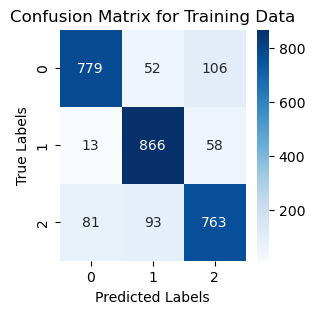

Confusion Matrix for Test Data:


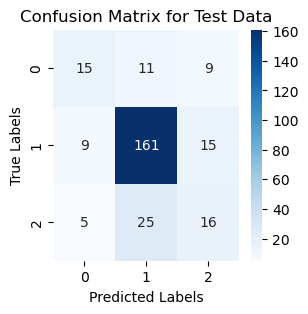

Confusion Matrix for Validation Data:


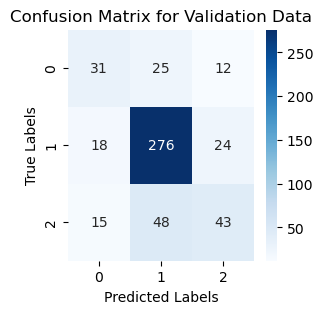

In [14]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid SVM

In [15]:
model = SVC(random_state=123)

param_grid_svm = {
    'C' : [0.1, 1, 10,100],
    'kernel' : ['linear','rbf','poly','sigmoid'],
    'degree' : [2,3,4], # Relevant only for 'poly' kernel
    'gamma' : ['scale','auto'],
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_svm,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "macro"
model_name = "Param_grid_SVM"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 96 candidates, totalling 384 fits
Best Hyperparameters for Param_grid_SVM: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation for Param_grid_SVM: 0.8264
Train Accuracy: 0.9691
Test Accuracy: 0.6992
Valid Accuracy: 0.6728
Precision Unseen %: 36.51
Accuracy Unseen %: 31.53

    rank_test_score  mean_test_score  std_test_score param_C param_degree  \
58                1         0.826413        0.042374      10            3   
62                2         0.824991        0.045647      10            3   
61                3         0.817172        0.089463      10            3   
53                3         0.817172        0.089463      10            2   
69                3         0.817172        0.089463      10            4   
..              ...              ...             ...     ...          ...   
55               92         0.566356        0.038641      10            2   
63               92         0.566356        0.038641 

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


## Decision Tree (DT)

### Default DT

In [16]:
insert_model = DecisionTreeClassifier(random_state=123)
model_name = "DT"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'DT',
 'Train Accuracy': 1.0,
 'Test Accuracy': 0.6316,
 'Valid Accuracy': 0.6159,
 'Train ACC Error': 0.0,
 'Test ACC Error': 0.3684,
 'Valid ACC Error': 0.3841}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       937
           1       1.00      1.00      1.00       937
           2       1.00      1.00      1.00       937

    accuracy                           1.00      2811
   macro avg       1.00      1.00      1.00      2811
weighted avg       1.00      1.00      1.00      2811

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.32      0.29      0.30        35
           1       0.82      0.76      0.79       185
           2       0.28      0.39      0.32        46

    accuracy                           0.63       266
   macro avg       0.47      0.48      0.47       266
weighted avg       0.66      0.63      0.64       266

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.35      0.47      0.40        68
        

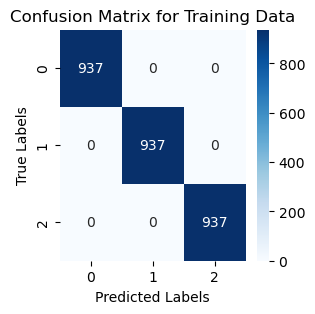

Confusion Matrix for Test Data:


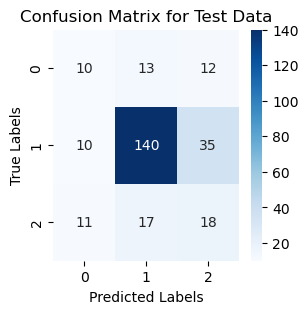

Confusion Matrix for Validation Data:


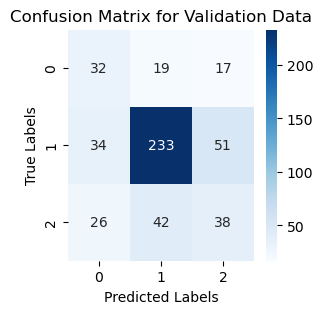

In [17]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid DT

In [18]:
model = DecisionTreeClassifier(random_state=123, 
    max_depth=10, 
    min_samples_split=5, 
    min_samples_leaf=4
)

param_grid_dt = {
    'criterion': ['gini', 'entropy'],             # Quality measure of a split
    'max_depth': [None, 10, 20, 30, 40, 50],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],                # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]                   # Minimum samples required at a leaf node
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_dt,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_DT"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best Hyperparameters for Param_grid_DT: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation for Param_grid_DT: 0.757
Train Accuracy: 1.0
Test Accuracy: 0.6241
Valid Accuracy: 0.5976
Precision Unseen %: 42.74
Accuracy Unseen %: 37.84

    rank_test_score  mean_test_score  std_test_score param_criterion  \
54                1         0.757038        0.045655         entropy   
99                1         0.757038        0.045655         entropy   
81                1         0.757038        0.045655         entropy   
90                1         0.757038        0.045655         entropy   
57                5         0.754550        0.042542         entropy   
..              ...              ...             ...             ...   
65              104         0.719687        0.047393         entropy   
71              105         0.717557        0.047147         entro

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


## Random Forest (RF)

### Default RF

In [19]:
insert_model = RandomForestClassifier(random_state=123)
model_name = "RF"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'RF',
 'Train Accuracy': 1.0,
 'Test Accuracy': 0.7782,
 'Valid Accuracy': 0.7195,
 'Train ACC Error': 0.0,
 'Test ACC Error': 0.2218,
 'Valid ACC Error': 0.2805}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       937
           1       1.00      1.00      1.00       937
           2       1.00      1.00      1.00       937

    accuracy                           1.00      2811
   macro avg       1.00      1.00      1.00      2811
weighted avg       1.00      1.00      1.00      2811

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.65      0.37      0.47        35
           1       0.86      0.93      0.89       185
           2       0.49      0.48      0.48        46

    accuracy                           0.78       266
   macro avg       0.66      0.59      0.62       266
weighted avg       0.77      0.78      0.77       266

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.59      0.40      0.47        68
        

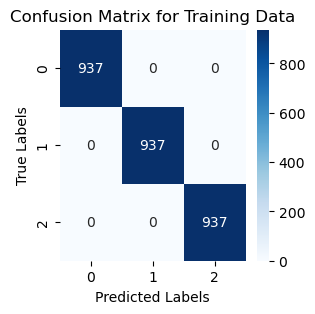

Confusion Matrix for Test Data:


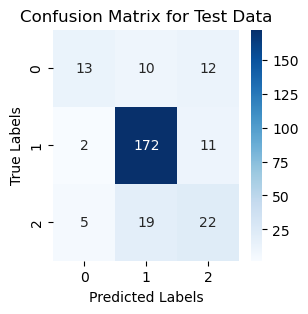

Confusion Matrix for Validation Data:


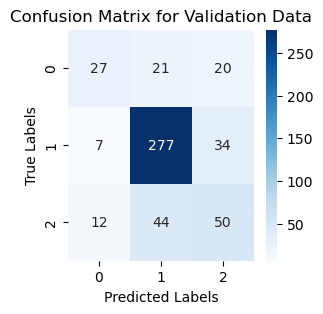

In [20]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid RF

In [21]:
model = RandomForestClassifier(
    random_state=123, 
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=5, 
    min_samples_leaf=4, 
    max_features='sqrt'
)

param_grid_rf = {
    'n_estimators' : [10,50,100,200],
    'criterion' : ['gini','entropy'],
    'max_depth' : [None, 1, 5, 10, 15, 20],
    'min_samples_split' : [2,5,10],
    'min_samples_leaf' : [1,2,4],
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_rf,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_RF"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 432 candidates, totalling 1728 fits
Best Hyperparameters for Param_grid_RF: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation for Param_grid_RF: 0.8684
Train Accuracy: 1.0
Test Accuracy: 0.7744
Valid Accuracy: 0.7297
Precision Unseen %: 77.78
Accuracy Unseen %: 33.33

     rank_test_score  mean_test_score  std_test_score param_criterion  \
3                  1         0.868388        0.066644            gini   
183                2         0.865896        0.066355            gini   
182                3         0.864829        0.067238            gini   
2                  4         0.864119        0.064780            gini   
363                5         0.861982        0.067351         entropy   
..               ...              ...             ...             ...   
261              424         0.583781        0.017832         entropy   
281              424         0.583781 

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## Gradient Boosting (GB)

### Default GB

In [22]:
insert_model = GradientBoostingClassifier(random_state=123)
model_name = "GB"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'GB',
 'Train Accuracy': 0.8894,
 'Test Accuracy': 0.7444,
 'Valid Accuracy': 0.7256,
 'Train ACC Error': 0.1106,
 'Test ACC Error': 0.2556,
 'Valid ACC Error': 0.2744}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       937
           1       0.88      0.94      0.91       937
           2       0.86      0.86      0.86       937

    accuracy                           0.89      2811
   macro avg       0.89      0.89      0.89      2811
weighted avg       0.89      0.89      0.89      2811

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.48      0.31      0.38        35
           1       0.86      0.91      0.88       185
           2       0.40      0.41      0.41        46

    accuracy                           0.74       266
   macro avg       0.58      0.55      0.56       266
weighted avg       0.73      0.74      0.73       266

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.53      0.43      0.47        68
        

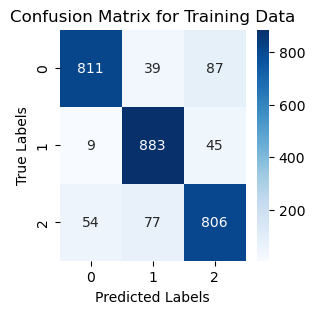

Confusion Matrix for Test Data:


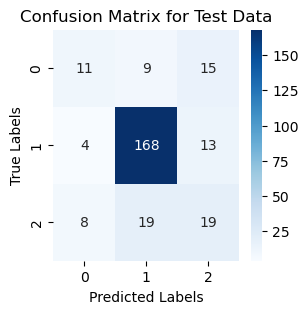

Confusion Matrix for Validation Data:


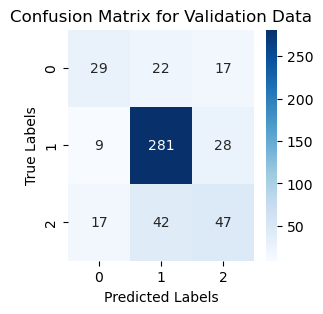

In [23]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid GB

In [24]:
model = GradientBoostingClassifier(
    random_state=123, 
    n_estimators=50, 
    learning_rate=0.1, 
    max_depth=3, 
    subsample=0.8
)

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'subsample': [0.8, 0.9]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_gb,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_GB"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 96 candidates, totalling 384 fits
Best Hyperparameters for Param_grid_GB: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation for Param_grid_GB: 0.8549
Train Accuracy: 0.9943
Test Accuracy: 0.7556
Valid Accuracy: 0.7419
Precision Unseen %: 77.78
Accuracy Unseen %: 33.33

    rank_test_score  mean_test_score  std_test_score param_learning_rate  \
89                1         0.854877        0.092403                 0.1   
94                2         0.854166        0.093937                 0.1   
82                3         0.852743        0.101788                 0.1   
83                4         0.852743        0.100104                 0.1   
88                5         0.852032        0.097604                 0.1   
..              ...              ...             ...                 ...   
6                91         0.666669        0.047467                0.01 

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


## XGBoost (XGB)

### Default XGB

In [25]:
insert_model = XGBClassifier(random_state=123)
model_name = "XGB"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'XGB',
 'Train Accuracy': 1.0,
 'Test Accuracy': 0.7556,
 'Valid Accuracy': 0.7358,
 'Train ACC Error': 0.0,
 'Test ACC Error': 0.2444,
 'Valid ACC Error': 0.2642}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       937
           1       1.00      1.00      1.00       937
           2       1.00      1.00      1.00       937

    accuracy                           1.00      2811
   macro avg       1.00      1.00      1.00      2811
weighted avg       1.00      1.00      1.00      2811

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.50      0.29      0.36        35
           1       0.86      0.92      0.89       185
           2       0.44      0.46      0.45        46

    accuracy                           0.76       266
   macro avg       0.60      0.55      0.57       266
weighted avg       0.74      0.76      0.74       266

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.57      0.44      0.50        68
        

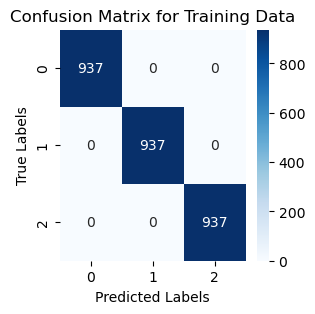

Confusion Matrix for Test Data:


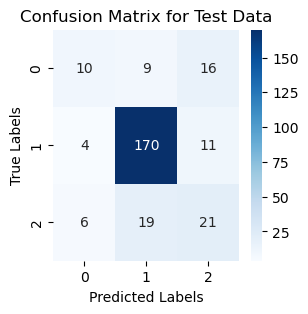

Confusion Matrix for Validation Data:


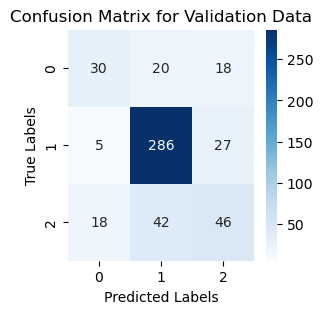

In [26]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid XGB

In [27]:
model = XGBClassifier(random_state=123)

param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'subsample': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_xgb,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_XGB"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 243 candidates, totalling 972 fits
Best Hyperparameters for Param_grid_XGB: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation for Param_grid_XGB: 0.8833
Train Accuracy: 1.0
Test Accuracy: 0.7444
Valid Accuracy: 0.7398
Precision Unseen %: 61.97
Accuracy Unseen %: 36.94

     rank_test_score  mean_test_score  std_test_score param_gamma  \
52                 1         0.883332        0.086647           0   
51                 2         0.881197        0.083200           0   
80                 3         0.880133        0.083095           0   
48                 4         0.880130        0.080956           0   
70                 5         0.879775        0.089186           0   
..               ...              ...             ...         ...   
5                238         0.657067        0.048588           0   
167              238         0.657067        0.048588         0.2   
83               24

## Naive Bayes (NB)

### Default NB

In [28]:
insert_model = GaussianNB()
model_name = "NB"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'NB',
 'Train Accuracy': 0.6613,
 'Test Accuracy': 0.6917,
 'Valid Accuracy': 0.6199,
 'Train ACC Error': 0.3387,
 'Test ACC Error': 0.3083,
 'Valid ACC Error': 0.3801}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.75      0.52      0.61       937
           1       0.75      0.76      0.75       937
           2       0.55      0.71      0.62       937

    accuracy                           0.66      2811
   macro avg       0.68      0.66      0.66      2811
weighted avg       0.68      0.66      0.66      2811

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.44      0.49      0.46        35
           1       0.84      0.80      0.82       185
           2       0.37      0.41      0.39        46

    accuracy                           0.69       266
   macro avg       0.55      0.57      0.56       266
weighted avg       0.71      0.69      0.70       266

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.47      0.44      0.45        68
        

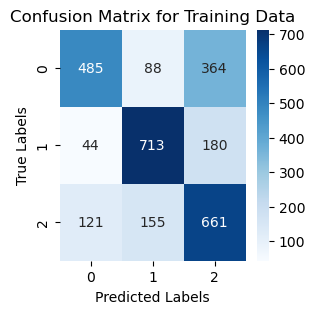

Confusion Matrix for Test Data:


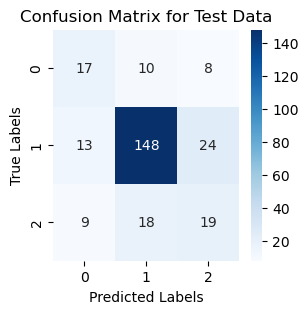

Confusion Matrix for Validation Data:


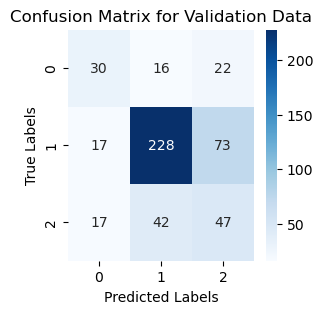

In [29]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid NB

In [30]:
model = GaussianNB(var_smoothing=1e-9)

param_grid_nb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_nb,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_NB"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best Hyperparameters for Param_grid_NB: {'var_smoothing': 1e-05}
Best cross-validation for Param_grid_NB: 0.63
Train Accuracy: 0.6613
Test Accuracy: 0.6917
Valid Accuracy: 0.6199
Precision Unseen %: 44.34
Accuracy Unseen %: 32.43

   rank_test_score  mean_test_score  std_test_score param_var_smoothing
4                1         0.630032        0.091669             0.00001
3                2         0.628254        0.094676            0.000001
2                3         0.626476        0.097688                 0.0
1                4         0.625409        0.099497                 0.0
0                5         0.622209        0.104933                 0.0


C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


## K-Nearest Neighbors (KNN)

### Default KNN

In [31]:
insert_model = KNeighborsClassifier()
model_name = "KNN"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'KNN',
 'Train Accuracy': 0.8637,
 'Test Accuracy': 0.6466,
 'Valid Accuracy': 0.6199,
 'Train ACC Error': 0.1363,
 'Test ACC Error': 0.3534,
 'Valid ACC Error': 0.3801}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       937
           1       0.92      0.79      0.85       937
           2       0.85      0.87      0.86       937

    accuracy                           0.86      2811
   macro avg       0.87      0.86      0.86      2811
weighted avg       0.87      0.86      0.86      2811

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.35      0.63      0.45        35
           1       0.84      0.71      0.77       185
           2       0.38      0.39      0.39        46

    accuracy                           0.65       266
   macro avg       0.53      0.58      0.54       266
weighted avg       0.70      0.65      0.66       266

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.36      0.53      0.43        68
        

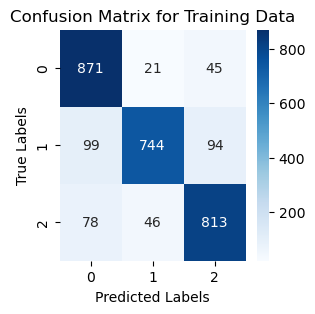

Confusion Matrix for Test Data:


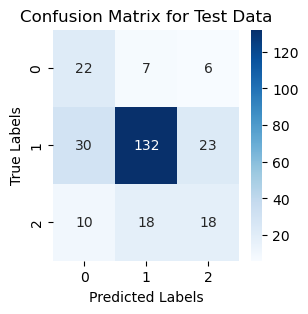

Confusion Matrix for Validation Data:


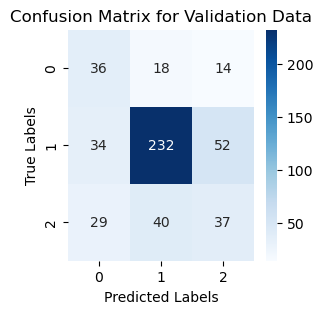

In [32]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid KNN

In [33]:
model = KNeighborsClassifier()

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_knn,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)
average = "weighted"
model_name = "Param_grid_KNN"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best Hyperparameters for Param_grid_KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best cross-validation for Param_grid_KNN: 0.867
Train Accuracy: 1.0
Test Accuracy: 0.6767
Valid Accuracy: 0.6565
Precision Unseen %: 27.99
Accuracy Unseen %: 34.23

    rank_test_score  mean_test_score  std_test_score param_n_neighbors  \
1                 1         0.866962        0.037425                 3   
5                 2         0.856648        0.036705                 5   
0                 3         0.850595        0.034509                 3   
9                 4         0.846688        0.034845                 7   
13                5         0.836728        0.034121                10   
4                 6         0.831741        0.024492                 5   
8                 7         0.811471        0.036723                 7   
7                 8         0.798666        0.046499                 5   
3                

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


## Logistic Regression (LR)

### Default LR

In [34]:
insert_model = LogisticRegression(random_state=123)
model_name = "LR"

valid_results = evaluate_validation_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
valid_list.append(valid_results)
    
test_results = evaluate_test_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled, X_test, Y_test)
test_list.append(test_results)

train_results = evaluate_train_default_models(insert_model, model_name, X_train_resampled, Y_train_resampled)
train_list.append(train_results)

train_results = default_accuracy_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)
acc_train_test_valid_list.append(train_results)

train_results

{'Model': 'LR',
 'Train Accuracy': 0.72,
 'Test Accuracy': 0.7444,
 'Valid Accuracy': 0.6768,
 'Train ACC Error': 0.28,
 'Test ACC Error': 0.2556,
 'Valid ACC Error': 0.3232}

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       937
           1       0.78      0.87      0.82       937
           2       0.64      0.64      0.64       937

    accuracy                           0.72      2811
   macro avg       0.72      0.72      0.72      2811
weighted avg       0.72      0.72      0.72      2811

Classification Report for Test Data:
              precision    recall  f1-score   support

           0       0.56      0.43      0.48        35
           1       0.86      0.88      0.87       185
           2       0.41      0.46      0.43        46

    accuracy                           0.74       266
   macro avg       0.61      0.59      0.60       266
weighted avg       0.74      0.74      0.74       266

Classification Report for Validation Data:
              precision    recall  f1-score   support

           0       0.45      0.51      0.48        68
        

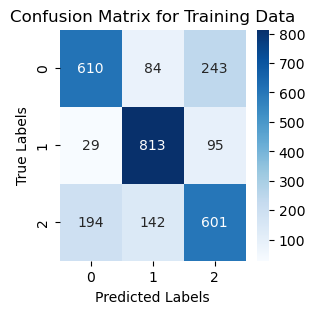

Confusion Matrix for Test Data:


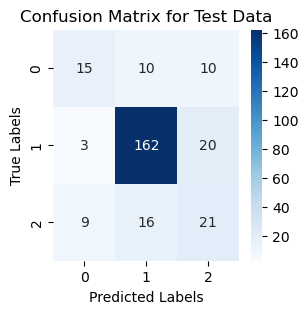

Confusion Matrix for Validation Data:


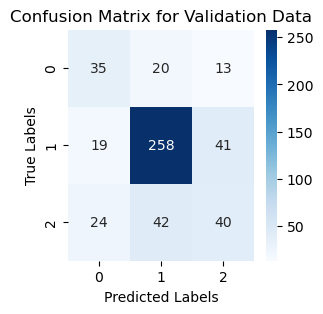

In [35]:
default_classification_confusion_train_valid_test_model(insert_model, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test)

### Param_grid LR

In [36]:
model = LogisticRegression(random_state=123)
    
def get_param_grid_lr(solver):
    if solver == 'liblinear':
        return {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': [solver],
            'penalty': ['l1', 'l2']
        }
    elif solver == 'lbfgs':
        return {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': [solver],
            'penalty': ['l2']
        }
    else:
        raise ValueError("Unsupported solver")

param_grid_lib = get_param_grid_lr('liblinear')

insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_lib,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)
average = "weighted"
model_name = "Param_grid_LR(lib)"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Hyperparameters for Param_grid_LR(lib): {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation for Param_grid_LR(lib): 0.6941
Train Accuracy: 0.7101
Test Accuracy: 0.7293
Valid Accuracy: 0.6829
Precision Unseen %: 60.54
Accuracy Unseen %: 40.54

   rank_test_score  mean_test_score  std_test_score param_C param_penalty  \
4                1         0.694070        0.053385       1            l1   
5                2         0.693714        0.054057       1            l2   
8                3         0.692648        0.054266     100            l1   
9                3         0.692648        0.054266     100            l2   
6                5         0.692647        0.053442      10            l1   
7                6         0.692291        0.054056      10            l2   
3                7         0.686953        0.053642     0.1            l2   
2                8         0.686595        0.049466     

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [37]:
param_grid_lbf = get_param_grid_lr('lbfgs')
insert_model_hyperparameter = GridSearchCV(
    model,
    param_grid_lbf,
    cv=4,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)
model_name = "Param_grid_LR(lbfgs)"

hyper_results = hypertune_and_evaluate_model(insert_model_hyperparameter, model_name, X_train_resampled, Y_train_resampled, X_val, Y_val, X_test, Y_test, X_unseen, Y_unseen_true, average)
hyper_list.append(hyper_results)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Best Hyperparameters for Param_grid_LR(lbfgs): {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation for Param_grid_LR(lbfgs): 0.6987
Train Accuracy: 0.72
Test Accuracy: 0.7444
Valid Accuracy: 0.6768
Precision Unseen %: 59.6
Accuracy Unseen %: 36.94

   rank_test_score  mean_test_score  std_test_score param_C param_penalty  \
2                1         0.698695        0.052905       1            l2   
3                2         0.697982        0.053375      10            l2   
4                3         0.697271        0.054601     100            l2   
1                4         0.696203        0.050577     0.1            l2   
0                5         0.683036        0.044984    0.01            l2   

  param_solver  
2        lbfgs  
3        lbfgs  
4        lbfgs  
1        lbfgs  
0        lbfgs  


C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Overall comparison between default models

    Accuracy: Overall correctness of the model. Higher is generally better.
    
    Precision: Proportion of true positives among predicted positives. Higher is better, especially if false positives are costly.
    
    F1-Score: Harmonic mean of precision and recall. Balances precision and recall. Higher is better.
    
    Error Rate: Proportion of incorrect predictions. Lower is better.
    
    Cross-Validation Mean Accuracy: Average accuracy across different data subsets. Higher is better.
    
    Cross-Validation Standard Deviation: Variability of accuracy across folds. Lower is better.

In [38]:
# Show results in a table
showTablulate("Valid resutlts of Default Models", valid_list, 0)
showTablulate("Test resutlts of Default Models", test_list, 0)
showTablulate("Train resutlts of Default Models", train_list, 1)
showTablulate("Train, test, validation accuracy resutlts of Default Models", acc_train_test_valid_list, 2)

Valid resutlts of Default Models
+---------+------------+-------------+----------+--------------+--------------+
| Model   |   Accuracy |   Precision |   Recall |   F1-Support |   Error Rate |
+=========+============+=============+==========+==============+==============+
| SVM     |     0.7218 |      0.7056 |   0.7218 |       0.7123 |       0.2782 |
+---------+------------+-------------+----------+--------------+--------------+
| DT      |     0.6316 |      0.6631 |   0.6316 |       0.6445 |       0.3684 |
+---------+------------+-------------+----------+--------------+--------------+
| RF      |     0.7782 |      0.7652 |   0.7782 |       0.7656 |       0.2218 |
+---------+------------+-------------+----------+--------------+--------------+
| GB      |     0.7444 |      0.729  |   0.7444 |       0.7339 |       0.2556 |
+---------+------------+-------------+----------+--------------+--------------+
| XGB     |     0.7556 |      0.7386 |   0.7556 |       0.7425 |       0.2444 |
+------

### Cross-Validation between default models

In [39]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
cv_list = []

SVM_default = SVC(random_state=123)
DT_default = DecisionTreeClassifier(random_state=123)
RF_default = RandomForestClassifier(random_state=123)
GB_default = GradientBoostingClassifier(random_state=123)
XGB_default = XGBClassifier(random_state=123)
NB_default = GaussianNB()
KNN_default = KNeighborsClassifier()
LR_default = LogisticRegression(random_state=123)

models = [SVM_default, DT_default, RF_default, GB_default, XGB_default, NB_default, KNN_default, LR_default]
model_names = ['SVC', 'DT', 'RF', 'GB', 'XGB', 'NB', 'KNN', 'LR']

for model, name in zip(models, model_names):
    cv_results = cross_validate_default_model(model, name, cv, X_train_resampled, Y_train_resampled)
    cv_list.append(cv_results)

showTablulate("Cross-validation resutlts of Default Models", cv_list, 4)

Cross-validation resutlts of Default Models
+---------+----------------------------------------+-----------+----------+
| Model   | CV score                               |   Mean CV |   Std CV |
+=========+========================================+===========+==========+
| SVC     | 0.7815, 0.7883, 0.7794, 0.7527, 0.7331 |    0.767  |   0.0208 |
+---------+----------------------------------------+-----------+----------+
| DT      | 0.7744, 0.7153, 0.7722, 0.7509, 0.7331 |    0.7492 |   0.0227 |
+---------+----------------------------------------+-----------+----------+
| RF      | 0.8952, 0.8772, 0.8683, 0.8559, 0.8505 |    0.8694 |   0.0159 |
+---------+----------------------------------------+-----------+----------+
| GB      | 0.8259, 0.8238, 0.8149, 0.7918, 0.7900 |    0.8093 |   0.0155 |
+---------+----------------------------------------+-----------+----------+
| XGB     | 0.8899, 0.8701, 0.8897, 0.8843, 0.8950 |    0.8858 |   0.0085 |
+---------+---------------------------------

    High Mean CV Score: Ensures that the model is capable of achieving good accuracy.
    Low Std CV: Ensures that the model's performance is reliable and generalizes well across different datasets.
    
    Example
    Consider two models:
        Model A: Mean CV = 0.90, Std CV = 0.02
        Model B: Mean CV = 0.88, Std CV = 0.01
    
        Model A has a higher mean CV score but also a higher standard deviation, suggesting that while it performs better on average, it might be less consistent.
        Model B has a slightly lower mean CV score but with a lower standard deviation, indicating more consistent performance.

## Overall comparison between param_grid (Hypertunned) models

In [40]:
showTablulate("Hypertunning resutlts of Models", hyper_list, 3)

Hypertunning resutlts of Models
+----------------------+----------------------+------------------+-----------------+------------------+----------------------+---------------------+
| Model                | Best HP.             |   Train Accuracy |   Test Accuracy |   Valid Accuracy |   Precision Unseen % |   Accuracy Unseen % |
+======================+======================+==================+=================+==================+======================+=====================+
| Param_grid_SVM       | C: 10                |           0.9691 |          0.6992 |           0.6728 |                36.51 |               31.53 |
|                      | degree: 3            |                  |                 |                  |                      |                     |
|                      | gamma: scale         |                  |                 |                  |                      |                     |
|                      | kernel: poly         |                  |        

# Neutral Network

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

## function

In [42]:
def pickScaler(sc, X_train_resampled, X_val, X_test, X_unseen):
    # Check if the scaler is a StandardScaler
    if isinstance(sc, StandardScaler):
        X_train_resampled_scaled = X_train_resampled
        X_val_scaled = X_val
        X_test_scaled = X_test
        X_unseen_scaled = X_unseen
        scaler_name = "StandardScaler"
    else:
        scaler = sc
        X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        X_unseen_scaled = scaler.transform(X_unseen)

        # Determine the type of scaler used
        if isinstance(scaler, MinMaxScaler):
            scaler_name = "MinMaxScaler"
        elif isinstance(scaler, RobustScaler):
            scaler_name = "RobustScaler"

    return X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name


def build_wo_valid_model(scaler_name, epochs, batch_size, A, B, C, D):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(Y_train_resampled_categorical.shape[1], activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train_resampled_scaled,
        Y_train_resampled_categorical,
        epochs=epochs,
        batch_size=batch_size,
    )

    # Evaluate the model on the training data
    train_loss, train_accuracy = model.evaluate(A, B, verbose=0)
    
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(C, D, verbose=0)
    
    # Round the metrics to 4 decimal places
    train_loss = round(train_loss, 4)
    train_accuracy = round(train_accuracy, 4)
    test_loss = round(test_loss, 4)
    test_accuracy = round(test_accuracy, 4)
    
    # Prepare results
    results = {
        'Model': "Sequential()",
        'Scaler': scaler_name,
        'Train loss': train_loss,
        'Train accuracy': train_accuracy,
        'Test loss': test_loss,
        'Test accuracy': test_accuracy
    }
    return train_loss, train_accuracy, test_loss, test_accuracy, results, history



def build_valid_model(scaler_name, epochs, batch_size, X_val_scaled, Y_val_categorical, A, B, C, D):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(Y_train_resampled_categorical.shape[1], activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(
        X_train_resampled_scaled,
        Y_train_resampled_categorical,
        epochs=50,
        batch_size=32,
        validation_data=(X_val_scaled, Y_val_categorical),
        verbose=-1
    )
    
    # Evaluate the model on the training and test data
    train_loss, train_accuracy = model.evaluate(A, B, verbose=0)
    test_loss, test_accuracy = model.evaluate(C, D, verbose=0)

    # Extract best validation accuracy from the history
    best_val_accuracy = max(history.history['val_accuracy'])
    
    # Round the metrics to 4 decimal places
    train_loss = round(train_loss, 4)
    train_accuracy = round(train_accuracy, 4)
    test_loss = round(test_loss, 4)
    test_accuracy = round(test_accuracy, 4)
    best_val_accuracy = round(best_val_accuracy, 4)
    
    # Prepare results
    results = {
        'Model': "Sequential()",
        'Scaler': scaler_name,
        'Train loss': train_loss,
        'Train accuracy': train_accuracy,
        'Test loss': test_loss,
        'Test accuracy': test_accuracy,
        'Best Valid accuracy': best_val_accuracy
    }
    return train_loss, train_accuracy, test_loss, test_accuracy, results, history



def plot_wo_valid_loss_accuracy(history, input_1, input_2, loss, accuracy):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[input_1], label=loss)
    plt.title(loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history[input_2], label=accuracy)
    plt.title(accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


def plot_valid_train(history, input_1, input_2, t_loss, v_loss, title_1, input_3, input_4, t_acc, v_acc, title_2):
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    plt.plot(history.history[input_1], label=t_loss)
    plt.plot(history.history[input_2], label=v_loss)
    plt.title(title_1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(history.history[input_3], label=t_acc)
    plt.plot(history.history[input_4], label=v_acc)
    plt.title(title_2)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



wo_val_list = []
val_list = []

def showNNTablulate(txt, results_list, wo_valid=False):
    if wo_valid==True:
        headers = ['Model', 'Scaler', 'Train loss', 'Train accuracy', 'Test loss', 'Test accuracy']
    else:
        headers = ['Model', 'Scaler', 'Train loss', 'Train accuracy', 'Test loss', 'Test accuracy', 'Best Valid accuracy']
        
    # Convert list of dictionaries to list of lists
    table_data = []
    for result in results_list:
        row = [result.get(header, 'N/A') for header in headers]  # Use 'N/A' for missing data
        table_data.append(row)

    # Use tabulate to format the results into a table
    table = tabulate(table_data, headers=headers, tablefmt='grid')

    # Print the table
    print(f"{txt}")
    print(table)
    print('\n')

In [43]:
input_a = 'loss'
input_b = 'accuracy'
loss = 'Training loss'
accuracy = 'Training Accuracy'
input_2 = 'val_loss'
input_4 = 'val_accuracy'
v_loss = 'Test loss'
v_acc = 'Test accuracy'
title_1 = 'Training and Test Loss'
title_2 = 'Training and Test Accuracy'

## StandardScaler

### without validation data

In [44]:
# One-hot encode labels
Y_train_resampled_categorical = to_categorical(Y_train_resampled)
Y_val_categorical = to_categorical(Y_val)
Y_test_categorical = to_categorical(Y_test)

In [45]:
X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name = pickScaler(StandardScaler(), X_train_resampled, X_val, X_test, X_unseen)
epoch = 50
batch_size = 32
train_loss, train_accuracy, test_loss, test_accuracy, results, history = build_wo_valid_model(scaler_name, epoch, batch_size, X_train_resampled_scaled, 
                                                                    Y_train_resampled_categorical, X_test_scaled, Y_test_categorical)
wo_val_list.append(results)

Epoch 1/50
88/88 [==============================] - 3s 3ms/step - loss: 0.6832 - accuracy: 0.3458
Epoch 2/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6398 - accuracy: 0.4522
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.5190
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 0.5744 - accuracy: 0.4980
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: 0.5561 - accuracy: 0.4998
Epoch 6/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5415 - accuracy: 0.5443
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 0.5295 - accuracy: 0.5318
Epoch 8/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5176 - accuracy: 0.5518
Epoch 9/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5083 - accuracy: 0.5617
Epoch 10/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5007 - accuracy: 0.5660
Epoch 11/50
88/88 [

Train Accuracy: 0.6048, Train Loss: 0.4074
Test Accuracy: 0.1992, Test Loss: 0.7106


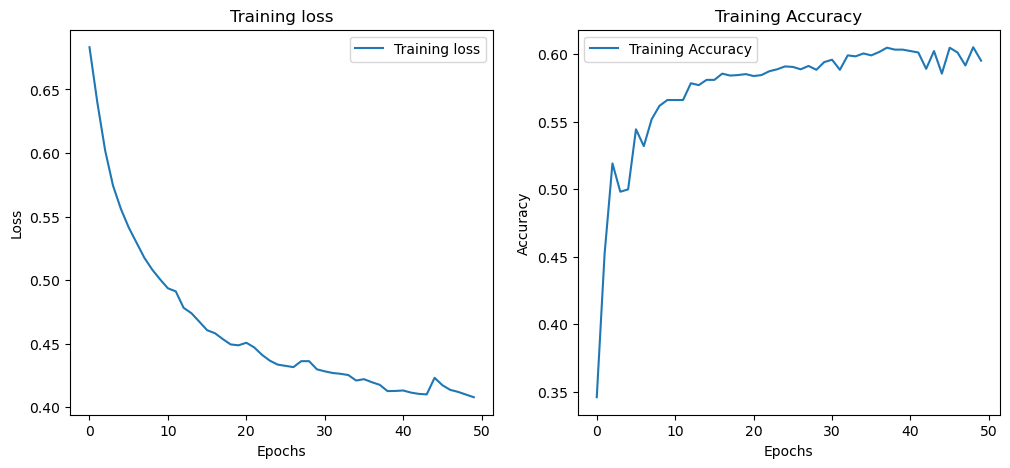

In [46]:
print(f'Train Accuracy: {train_accuracy}, Train Loss: {train_loss}')
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

plot_wo_valid_loss_accuracy(history, input_a, input_b, loss, accuracy)

### with validation data

In [47]:
train_loss, train_accuracy, test_loss, test_accuracy, results_val, history = build_valid_model(scaler_name, epoch, batch_size, X_val_scaled, 
                                                                         Y_val_categorical, X_train_resampled_scaled, Y_train_resampled_categorical, 
                                                                         X_test_scaled, Y_test_categorical)
val_list.append(results_val)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Training Loss: 0.351, Training Accuracy: 0.646
Test Loss: 0.865, Test Accuracy: 0.1992


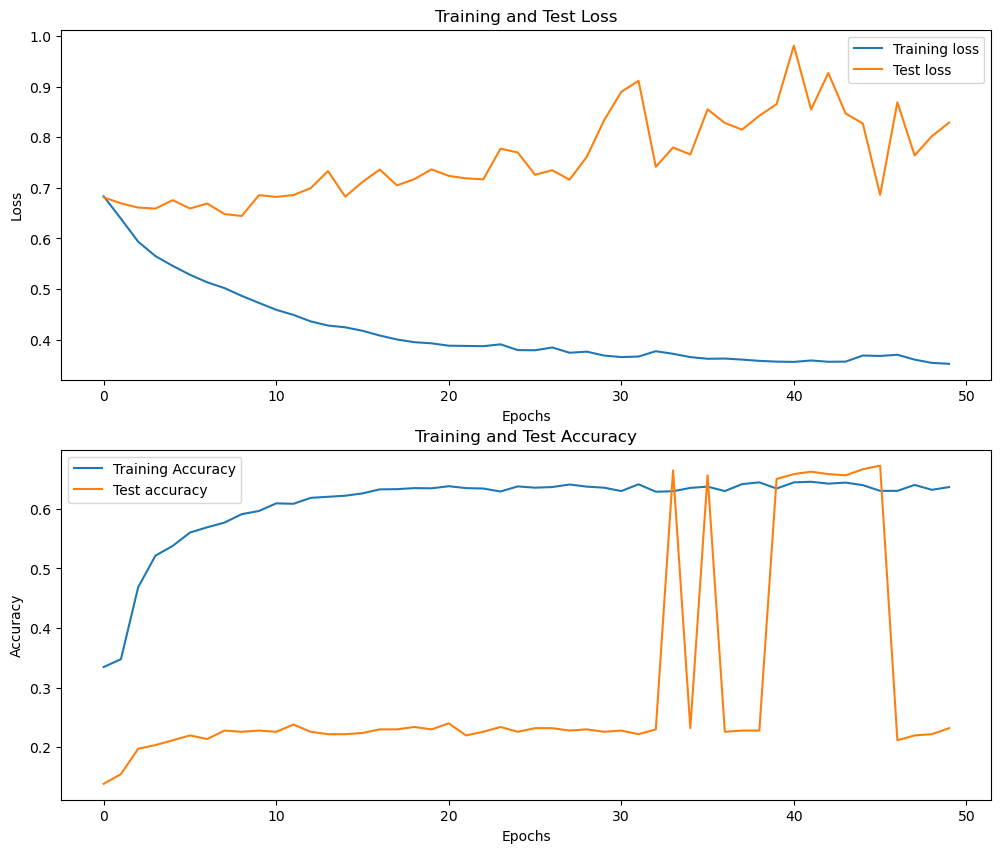

In [48]:
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plot_valid_train(history, input_a, input_2, loss, v_loss, title_1, input_b, input_4, accuracy, v_acc, title_2)

## MinMaxScaler

### without validation data

In [49]:
X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name = pickScaler(MinMaxScaler(), X_train_resampled, X_val, X_test, X_unseen)

epoch = 50
batch_size = 32
train_loss, train_accuracy, test_loss, test_accuracy, results, history = build_wo_valid_model(scaler_name, epoch, batch_size, X_train_resampled_scaled, 
                                                                    Y_train_resampled_categorical, X_test_scaled, Y_test_categorical)
wo_val_list.append(results)

C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


Epoch 1/50
88/88 [==============================] - 3s 3ms/step - loss: 0.6870 - accuracy: 0.3216
Epoch 2/50
88/88 [==============================] - 0s 4ms/step - loss: 0.6759 - accuracy: 0.3145
Epoch 3/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6670 - accuracy: 0.3223
Epoch 4/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.3305
Epoch 5/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6541 - accuracy: 0.3252
Epoch 6/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6497 - accuracy: 0.3266
Epoch 7/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6463 - accuracy: 0.3255
Epoch 8/50
88/88 [==============================] - 0s 2ms/step - loss: 0.6437 - accuracy: 0.3219
Epoch 9/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.3248
Epoch 10/50
88/88 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.3241
Epoch 11/50
88/88 [

Train Accuracy: 0.3333, Train Loss: 0.6365
Test Accuracy: 0.6955, Test Loss: 0.6364


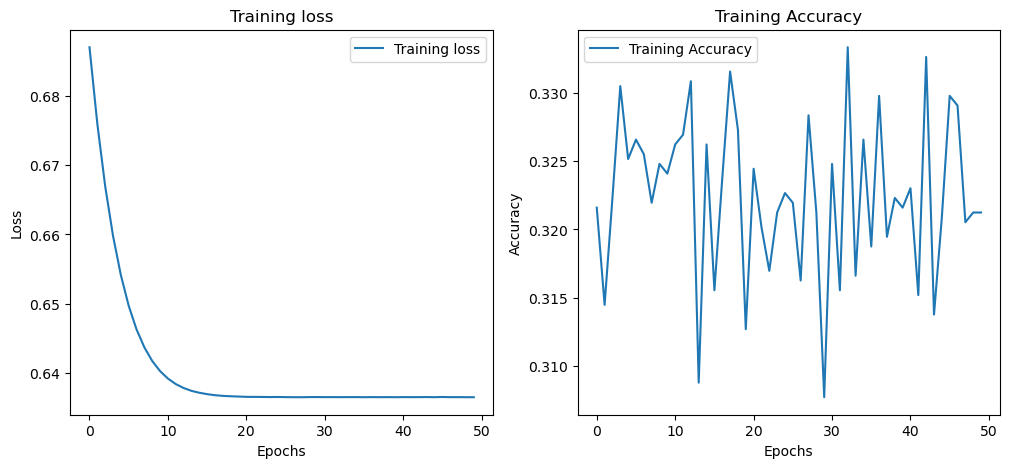

In [50]:
print(f'Train Accuracy: {train_accuracy}, Train Loss: {train_loss}')
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

plot_wo_valid_loss_accuracy(history, input_a, input_b, loss, accuracy)

### with validation data

In [51]:
train_loss, train_accuracy, test_loss, test_accuracy, results_val, history = build_valid_model(scaler_name, epoch, batch_size, X_val_scaled, 
                                                                         Y_val_categorical, X_train_resampled_scaled, Y_train_resampled_categorical, 
                                                                         X_test_scaled, Y_test_categorical)
val_list.append(results_val)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Training Loss: 0.2006, Training Accuracy: 0.9011
Test Loss: 0.6592, Test Accuracy: 0.6729


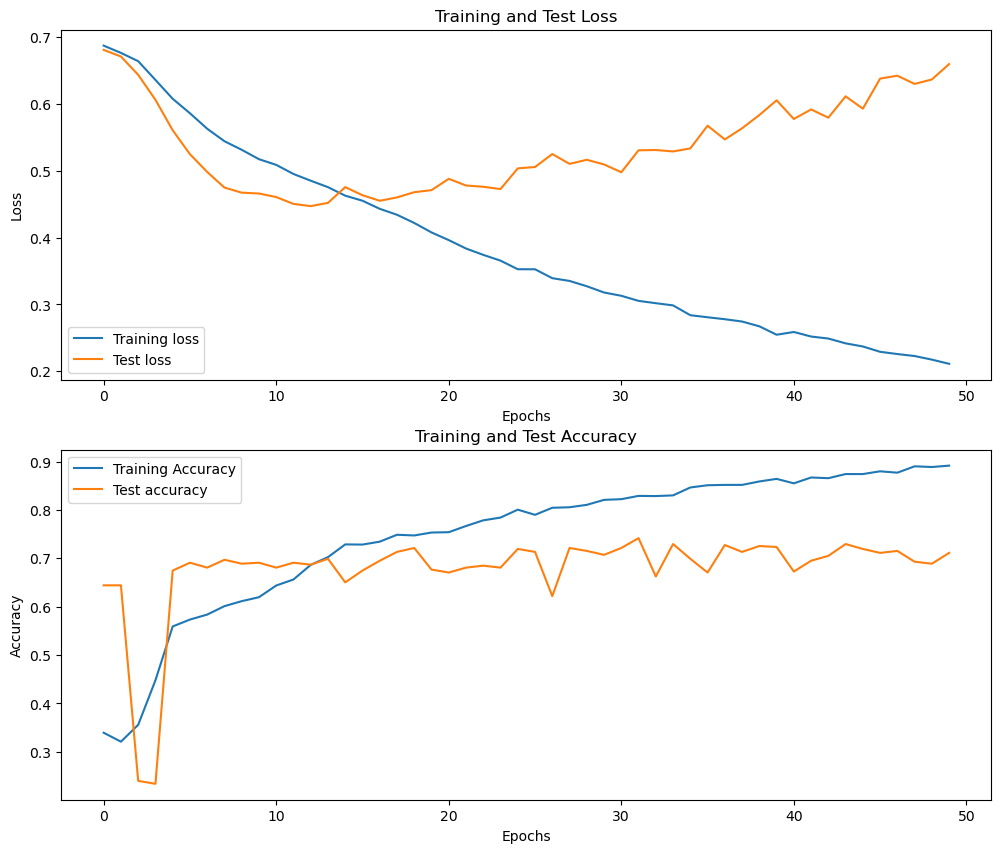

In [52]:
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plot_valid_train(history, input_a, input_2, loss, v_loss, title_1, input_b, input_4, accuracy, v_acc, title_2)

## RobustScaler

### without validation data

In [53]:
X_train_resampled_scaled, X_val_scaled, X_test_scaled, X_unseen_scaled, scaler_name = pickScaler(RobustScaler(), X_train_resampled, X_val, X_test, X_unseen)

epoch = 50
batch_size = 32
train_loss, train_accuracy, test_loss, test_accuracy, results, history = build_wo_valid_model(scaler_name, epoch, batch_size, X_train_resampled_scaled, 
                                                                    Y_train_resampled_categorical, X_test_scaled, Y_test_categorical)
wo_val_list.append(results)

Epoch 1/50


C:\Anaconda\envs\DS\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(


88/88 [==============================] - 2s 2ms/step - loss: 0.6528 - accuracy: 0.3340
Epoch 2/50
88/88 [==============================] - 0s 2ms/step - loss: 0.6076 - accuracy: 0.4564
Epoch 3/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5745 - accuracy: 0.5567
Epoch 4/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5524 - accuracy: 0.5902
Epoch 5/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5374 - accuracy: 0.6001
Epoch 6/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5225 - accuracy: 0.6080
Epoch 7/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5109 - accuracy: 0.6204
Epoch 8/50
88/88 [==============================] - 0s 2ms/step - loss: 0.5009 - accuracy: 0.6179
Epoch 9/50
88/88 [==============================] - 0s 2ms/step - loss: 0.4927 - accuracy: 0.6290
Epoch 10/50
88/88 [==============================] - 0s 2ms/step - loss: 0.4830 - accuracy: 0.6318
Epoch 11/50
88/88 [===========

Train Accuracy: 0.6784, Train Loss: 0.3507
Test Accuracy: 0.7068, Test Loss: 0.803


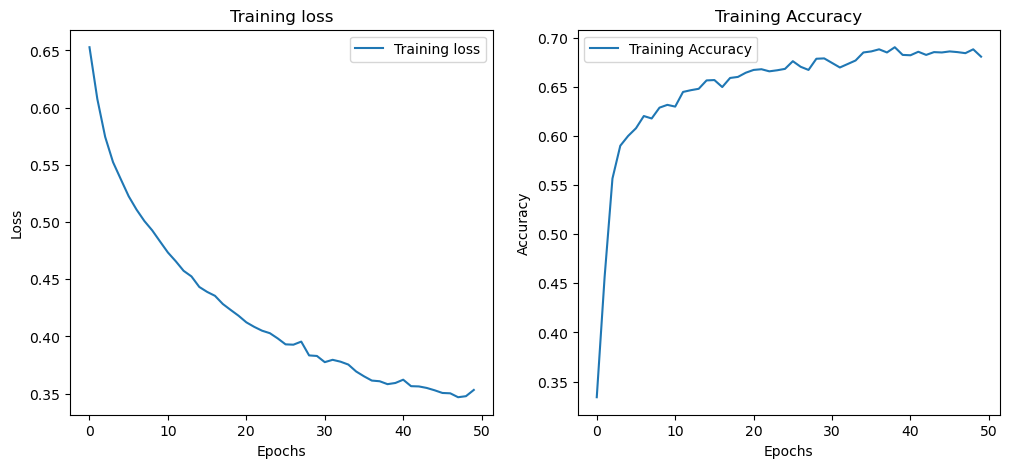

In [54]:
print(f'Train Accuracy: {train_accuracy}, Train Loss: {train_loss}')
print(f'Test Accuracy: {test_accuracy}, Test Loss: {test_loss}')

plot_wo_valid_loss_accuracy(history, input_a, input_b, loss, accuracy)

### with validation data

In [55]:
train_loss, train_accuracy, test_loss, test_accuracy, results_val, history = build_valid_model(scaler_name, epoch, batch_size, X_val_scaled, 
                                                                         Y_val_categorical, X_train_resampled_scaled, Y_train_resampled_categorical, 
                                                                         X_test_scaled, Y_test_categorical)
val_list.append(results_val)

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


Training Loss: 0.1499, Training Accuracy: 0.9235
Test Loss: 0.9392, Test Accuracy: 0.6842


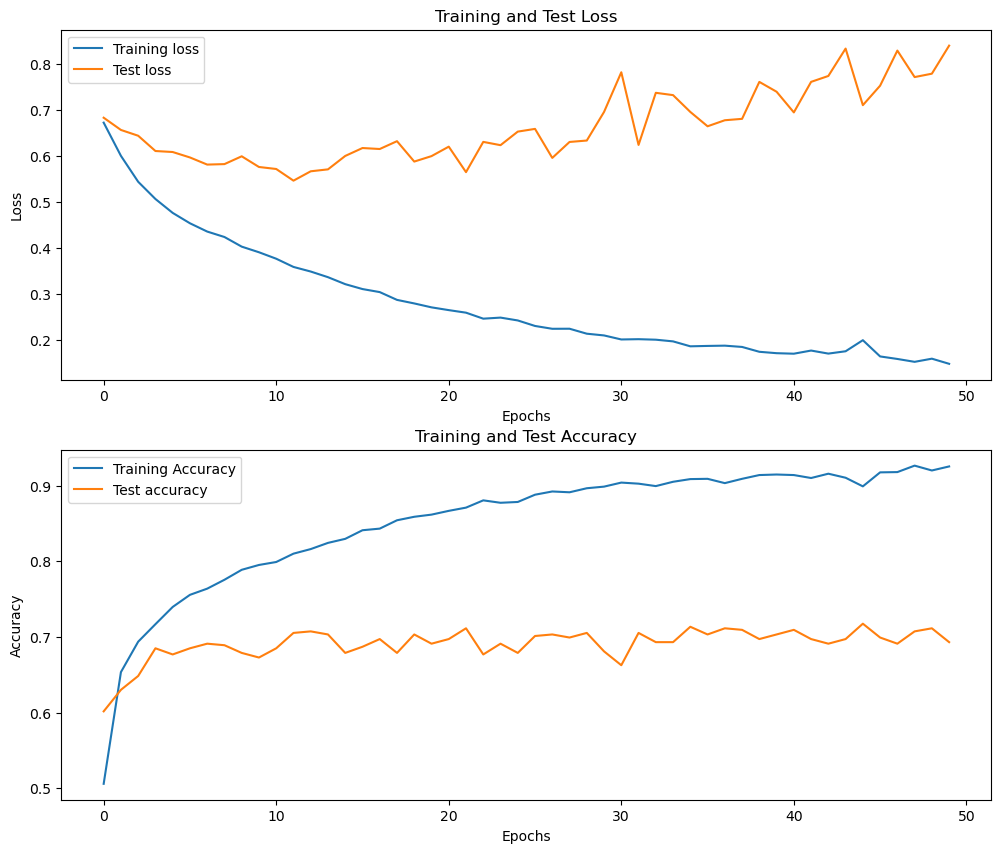

In [56]:
print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

plot_valid_train(history, input_a, input_2, loss, v_loss, title_1, input_b, input_4, accuracy, v_acc, title_2)

## Overall comparison between different scalers on NN

In [57]:
showNNTablulate("Overall Without Validation Data", wo_val_list, True)
showNNTablulate("Overall With Validation Data", val_list, False)

Overall Without Validation Data
+--------------+----------------+--------------+------------------+-------------+-----------------+
| Model        | Scaler         |   Train loss |   Train accuracy |   Test loss |   Test accuracy |
+==============+================+==============+==================+=============+=================+
| Sequential() | StandardScaler |       0.4074 |           0.6048 |      0.7106 |          0.1992 |
+--------------+----------------+--------------+------------------+-------------+-----------------+
| Sequential() | MinMaxScaler   |       0.6365 |           0.3333 |      0.6364 |          0.6955 |
+--------------+----------------+--------------+------------------+-------------+-----------------+
| Sequential() | RobustScaler   |       0.3507 |           0.6784 |      0.803  |          0.7068 |
+--------------+----------------+--------------+------------------+-------------+-----------------+


Overall With Validation Data
+--------------+----------------+----